# **download and import libraries**

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-350h99cu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-350h99cu
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=6500f44be7516cf7f60b57bad03f17d8631eae36ab2331ca00d608fba330f788
  Stored in directory: /tmp/pip-ephem-wheel-cache-kderv26k/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [ ]:
import torch
import clip
from PIL import Image
import os
import torchvision
import tarfile
import shutil
import zipfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid
import matplotlib
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 50.3MiB/s]


# **Download and unzip dataset**

In [ ]:
# Dowload the dataset
dataset_url = "https://warwick.ac.uk/fac/cross_fac/tia/data/extended_crc_grading/original_images.zip"
download_url(dataset_url, '.')

  0%|          | 0/20130314238 [00:00<?, ?it/s]

In [ ]:
with zipfile.ZipFile("./original_images.zip", 'r') as zip_ref:
    zip_ref.extractall("./Data")

In [ ]:
os.remove("./original_images.zip")

# **Find ROI**

In [ ]:
import os
import numpy as np
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu
import cv2

img = cv2.imread("./Data/Original_Images/Grade1_Patient_001_037570_046206.png")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

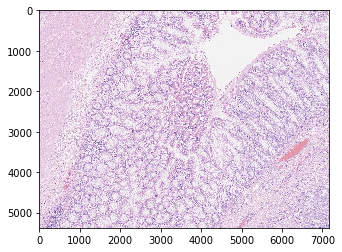

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(img_RGB, interpolation='nearest')
plt.show()

In [ ]:
img_HSV = rgb2hsv(img_RGB)

background_R = img_RGB[:, :, 0] > threshold_otsu(img_RGB[:, :, 0])
background_G = img_RGB[:, :, 1] > threshold_otsu(img_RGB[:, :, 1])
background_B = img_RGB[:, :, 2] > threshold_otsu(img_RGB[:, :, 2])
tissue_RGB = np.logical_not(background_R & background_G & background_B)
tissue_S = img_HSV[:, :, 1] > threshold_otsu(img_HSV[:, :, 1])
min_R = img_RGB[:, :, 0] > 2
min_G = img_RGB[:, :, 1] > 2
min_B = img_RGB[:, :, 2] > 2

tissue_mask = tissue_S & tissue_RGB & min_R & min_G & min_B

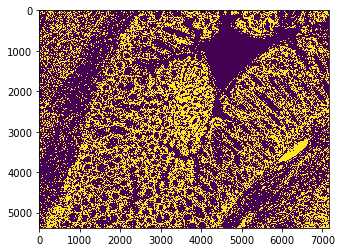

In [ ]:
plt.imshow(tissue_mask, interpolation='nearest')
plt.show()

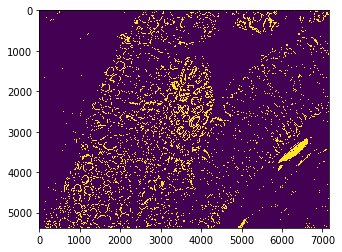

In [ ]:
kernel = np.ones((9,9), np.uint8)
opening = cv2.morphologyEx(tissue_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
plt.imshow(opening, interpolation='nearest')
plt.show()

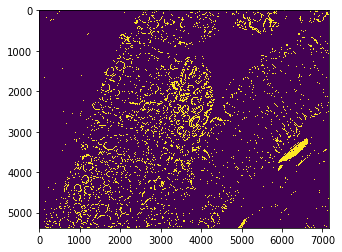

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (7, 7), (3, 3))
opening2 = cv2.morphologyEx(opening.astype(np.uint8), cv2.MORPH_OPEN, kernel)
plt.imshow(opening2, interpolation='nearest')
plt.show()

# **Patch Test**

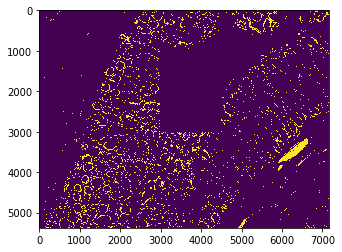

In [ ]:
import copy

test = copy.deepcopy(opening2)
test[1000:3000, 3000:4500] = 0
plt.imshow(test, interpolation='nearest')
plt.show()

In [ ]:
test = img_RGB[1000:3000, 3000:4500, :]
test.shape

(2000, 1500, 3)

In [ ]:
from PIL import Image
im = Image.fromarray(test)
im.save("your_file.jpeg")

In [ ]:
try:
  shutil.rmtree("./Patch")
except FileNotFoundError:
  pass

In [ ]:
os.mkdir("./Patch")
os.mkdir("./Patch/Grade1")
os.mkdir("./Patch/Grade2")
os.mkdir("./Patch/Grade3")

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("./Data/Original_Images/") if isfile(join("./Data/Original_Images/", f))]
final_files = []
for i in onlyfiles:
  if i.endswith(".png"):
    final_files.append(i)
len(final_files)

300

In [ ]:
def get_roi (address):
  img = cv2.imread(address)
  img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img_HSV = rgb2hsv(img_RGB)
  background_R = img_RGB[:, :, 0] > threshold_otsu(img_RGB[:, :, 0])
  background_G = img_RGB[:, :, 1] > threshold_otsu(img_RGB[:, :, 1])
  background_B = img_RGB[:, :, 2] > threshold_otsu(img_RGB[:, :, 2])
  tissue_RGB = np.logical_not(background_R & background_G & background_B)
  tissue_S = img_HSV[:, :, 1] > threshold_otsu(img_HSV[:, :, 1])
  min_R = img_RGB[:, :, 0] > 2
  min_G = img_RGB[:, :, 1] > 2
  min_B = img_RGB[:, :, 2] > 2
  tissue_mask = tissue_S & tissue_RGB & min_R & min_G & min_B

  kernel = np.ones((9,9), np.uint8)
  opening = cv2.morphologyEx(tissue_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (7, 7), (3, 3))
  return cv2.morphologyEx(opening.astype(np.uint8), cv2.MORPH_OPEN, kernel)

In [ ]:
grade1_counter = 0
grade2_counter = 0
grade3_counter = 0

for i in final_files:
  print(i)

  which_grade = -1
  grade_path = "./Patch/"
  if i.startswith("Grade1"):
    which_grade = 1
    grade_path += "Grade1/"
  elif i.startswith("Grade2"):
    which_grade = 2
    grade_path += "Grade2/"
  else:
    which_grade = 3
    grade_path += "Grade3/"

  full_path = "./Data/Original_Images/" + i
  main_image = cv2.imread(full_path)
  img_RGB = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)
  roi = get_roi(full_path)
  first_dimension = roi.shape[0]
  second_dimension = roi.shape[1]
  for j in range(first_dimension - 224):
    for k in range(second_dimension - 224):
      if roi[j, k] == 1:
        roi[j:j+224, k:k+224] = 0
        to_save = img_RGB[j:j+224, k:k+224, :]
        im = Image.fromarray(to_save)
        if which_grade == 1:
          im.save(grade_path + str(grade1_counter) + ".jpeg")
          grade1_counter += 1
        elif which_grade == 2:
          im.save(grade_path + str(grade2_counter) + ".jpeg")
          grade2_counter += 1
        else:
          im.save(grade_path + str(grade3_counter) + ".jpeg")
          grade3_counter += 1

  # because we don't have time
  if grade1_counter != 0 and grade2_counter != 0 and grade3_counter != 0:
    break

Grade3_Patient_083_082182_038275.png
Grade3_Patient_121_069347_012503.png
Grade2_Patient_004_038375_021884.png
Grade1_Patient_160_1.png


In [ ]:
onlyfiles1 = [f for f in listdir("./Patch/Grade1/") if isfile(join("./Patch/Grade1/", f))]
print("grade 1:", len(onlyfiles1))

onlyfiles2 = [f for f in listdir("./Patch/Grade2/") if isfile(join("./Patch/Grade2/", f))]
print("grade 2:", len(onlyfiles2))

onlyfiles3 = [f for f in listdir("./Patch/Grade3/") if isfile(join("./Patch/Grade3/", f))]
print("grade 3:", len(onlyfiles3))

print("total:", len(onlyfiles1) + len(onlyfiles2) + len(onlyfiles3))

grade 1: 3007
grade 2: 2399
grade 3: 4946
total: 10352


# **Finetune**

In [ ]:
data_dir = './Patch'
dataset = ImageFolder(data_dir, transform=ToTensor())
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(8282, 2070)

In [ ]:
batch_size=32
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, images, labels):
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, images, labels): 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
class CRC(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.clip = clip_model.visual
        self.network = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3))
        
    def forward(self, xb):
        xb = self.clip(xb)
        return self.network(xb)

In [ ]:
model = CRC()

In [ ]:
images_list = []

image, _ = dataset[100]
transform = T.ToPILImage()
image = transform(image)
image_input = preprocess(image).unsqueeze(0).to(device).squeeze()
images_list.append(np.asarray(image_input.cpu() if torch.cuda.is_available() else image_input))

image, _ = dataset[5000]
transform = T.ToPILImage()
image = transform(image)
image_input = preprocess(image).unsqueeze(0).to(device).squeeze()
images_list.append(np.asarray(image_input.cpu() if torch.cuda.is_available() else image_input))

images_list = np.asarray(images_list)
images_list = torch.from_numpy(images_list)

print(images_list.shape)

images_list = images_list.to(device)
model = model.to(device)
if torch.cuda.is_available():
  model = model.type(torch.cuda.FloatTensor)
output = model(images_list)
output.shape

torch.Size([2, 3, 224, 224])


torch.Size([2, 3])

In [ ]:
from tqdm import tqdm
import copy

transform = T.ToPILImage()

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = list()
    for images, labels in tqdm(val_loader):
      new_images = []
      for i, image in enumerate(images):
        image_input = preprocess(transform(image)).unsqueeze(0).to(device)
        image_input = image_input.squeeze()
        new_images.append(np.asarray(image_input.cpu()))
      new_images = np.asarray(new_images)
      new_images = torch.from_numpy(new_images)
      new_images = new_images.to(device)
      labels = labels.to(device)
      outputs.append(model.validation_step(new_images, labels))
    return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for images, labels in tqdm(train_loader):
            new_images = []
            for i, image in enumerate(images):
              image_input = preprocess(transform(image)).unsqueeze(0).to(device)
              image_input = image_input.squeeze()
              new_images.append(np.asarray(image_input.cpu()))
            new_images = np.asarray(new_images)
            new_images = torch.from_numpy(new_images)

            new_images = new_images.to(device)
            loss = model.training_step(new_images, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = CRC()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

CRC(
  (clip): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
 

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

if torch.cuda.is_available():
  model = model.type(torch.cuda.FloatTensor)
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

100%|██████████| 33/33 [00:15<00:00,  2.10it/s]


Epoch [0], train_loss: 0.7783, val_loss: 0.3858, val_acc: 0.8402


100%|██████████| 33/33 [00:15<00:00,  2.13it/s]


Epoch [1], train_loss: 0.2620, val_loss: 0.2194, val_acc: 0.9116


100%|██████████| 33/33 [00:15<00:00,  2.13it/s]


Epoch [2], train_loss: 0.1731, val_loss: 0.1110, val_acc: 0.9561


100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Epoch [3], train_loss: 0.1092, val_loss: 0.0830, val_acc: 0.9722


100%|██████████| 33/33 [00:15<00:00,  2.10it/s]


Epoch [4], train_loss: 0.0875, val_loss: 0.0722, val_acc: 0.9783


100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Epoch [5], train_loss: 0.0677, val_loss: 0.1525, val_acc: 0.9560


100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Epoch [6], train_loss: 0.0669, val_loss: 0.0870, val_acc: 0.9617


100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Epoch [7], train_loss: 0.0494, val_loss: 0.0885, val_acc: 0.9678


100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Epoch [8], train_loss: 0.0471, val_loss: 0.0861, val_acc: 0.9736


100%|██████████| 33/33 [00:15<00:00,  2.12it/s]


Epoch [9], train_loss: 0.0517, val_loss: 0.1266, val_acc: 0.9566


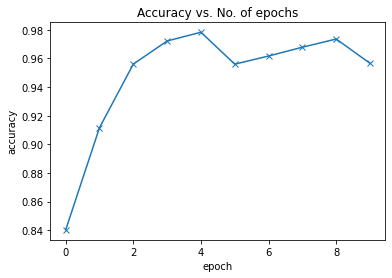

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

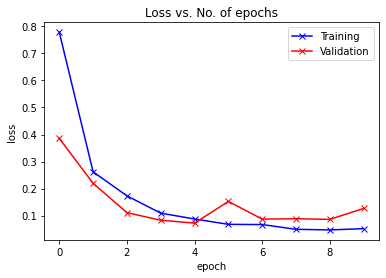

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')
model2 = to_device(CRC(), device)
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>